# II. Spatial Autocorrelation


## Пространственная автокорреляция

**Пространственная автокорреляция** — это статистический метод, который используется для измерения степени зависимости или сходства значений переменных в пространственно распределенных объектах: как значения переменной в одном месте соотносятся с значениями в соседних местах.

Если объекты, расположенные рядом друг с другом, имеют схожие значения, то это свидетельствует о высоком уровне пространственной автокорреляции. Напротив, если соседние объекты сильно различаются, то автокорреляция будет низкой.

### Виды пространственной автокорреляции:

1. **Положительная автокорреляция** — когда объекты, расположенные близко друг к другу, имеют схожие значения.
2. **Отрицательная автокорреляция** — когда объекты, расположенные рядом, имеют противоположные значения.
3. **Нулевая автокорреляция** — когда нет зависимости между значениями в соседних точках.


![Пространствннная автокорреляция](https://cdn.sanity.io/images/0xishpzy/production/ccd23afcc8667ee9c10b5e4a0c273d6dbe7779b3-680x383.png?w=2000&fit=max&auto=format)


## 0. Подготовка данных


Импортируем библиотеки


In [42]:
import geopandas as gpd
from pysal.explore import esda

import numpy as np

> В этом разделе мы будем работать с коэффициентом миграционного сальдо на 1000 человек за **2020 год** , который расчитан на уровне муниципальных образований **Краснодарского края и Республики Адыгея**.


**Загружаем данные о муниципалитетах для Краснодарского края и республики Адыгея**


In [43]:
muni = gpd.read_file('./data/krasnodar_adygea_muni.geojson')

muni.explore(
    column="netMigrationRate1000_2020",
    cmap="viridis",
    legend=True,
    tiles='cartodbpositron' 
)

## 1. Global Moran I


**Индекс Морана** — это один из наиболее часто используемых методов для оценки пространственной автокорреляции. Этот индекс измеряет, насколько значения переменной в соседних местах схожи. Он определяется по формуле:

$$
I = \frac{N}{W} \cdot
\frac{\sum_i \sum_j w_{ij}(x_i - \overline{x})(x_j - \overline{x})}
{\sum_i (x_i - \overline{x})^2}
$$

где:

- $N$ — количество наблюдений,
- $W$ — сумма всех весов в матрице соседства,
- $w_{ij}$ — вес (или мера близости) между объектами $i$ и $j$,
- $x_i$ и $x_j$ — значения переменной в точках $i$ и $j$,
- $\overline{x}$ — среднее значение переменной.

Значения индекса Морана интерпретируются следующим образом:

- $I > 0$ — положительная пространственная автокорреляция (соседние объекты схожи)
- $I < 0$ — отрицательная пространственная автокорреляция (соседние объекты сильно различаются)
- $I = 0$ — отсутствие пространственной автокорреляции


Наша **цель** понять, как устроен индекс Морана, поэтому сначала рассчитаем его **вручную**, последовательно выполняя все шаги, а затем сравним результат с расчётом через готовые функции.

Работаем с с коэффициентом миграционного сальдо на 1000 человек за **2020 год** на уровне муниципальных образований **Краснодарского края и Республики Адыгея** (как упоминали выше).


### "Ручной" расчет индекса Морана


#### ШАГ 1. Подготовка данных


**1.1. Исключение наблюдений с пропущенными значениями**

Перед расчётом индекса Морана из анализа исключаются муниципальные образования, для которых отсутствуют значения анализируемого показателя (NaN). Это необходимо, поскольку индекс Морана рассчитывается на основе сравнения значений показателя между соседними территориями. При отсутствии значения для отдельного объекта невозможно корректно учесть его вклад и вклад его соседей в общий показатель пространственной автокорреляции.


In [44]:
muni_clean = muni.copy()
muni_clean = muni_clean[muni_clean["netMigrationRate1000_2020"].notna()].reset_index(drop=True)

#### ШАГ 2. Матрица весов ( W )

На данном шаге определяется, **какие пространственные объекты считаются соседними**, то есть какие территории будут сравниваться между собой при расчёте индекса Морана.

Будем использоваь соседство типа _Queen_: два объекта считаются соседями, если они имеют общую границу или соприкасаются углами.

В предыдущем разделе, посвящённом **пространственному соседству**, матрица весов строилась с использованием инструментов библиотеки `libpysal.weights`. В данном разделе мы создадим матрицу весов **вручную**, чтобы наглядно показать принцип её построения.

**2.1. Матрица смежности (определение соседства)**

Посмтроим **матрицу смежности**, строки и столбцы которой соответствуют пространственным объектам ( в нашем случае - муниципальным образованиям).

В матрице будут записаны следующие значения:

- **1** — если соответствующие объекты являются соседями,
- **0** — если соседство между объектами отсутствует.


In [45]:
# n — количество пространственных объектов (полигонов)
n = len(muni_clean)

# Создаём пустую матрицу весов n × n
# Пока все элементы равны 0 (соседство не задано)
W = np.zeros((n, n))


# Проходим по всем парам объектов i и j
for i in range(n):
    for j in range(n):

        # Объект не может быть соседом самому себе
        if i != j:

            # Проверяем, соприкасаются ли два полигона
            # touches = общая граница или общая вершина (Queen-соседство)
            if muni_clean.geometry.iloc[i].touches(muni_clean.geometry.iloc[j]):

                # Если объекты i и j являются соседями,
                # записываем 1 в матрицу весов
                W[i, j] = 1


После построения матрицы смежности проводится проверка корректности её формирования. В качестве простой "диагностики" используется сумма всех элементов матрицы, которая отражает общее число соседских связей между объектами.


In [46]:
print("W.sum() =", W.sum())

# Доп. проверка: есть ли объекты без соседей (строка из нулей)
row_sums = W.sum(axis=1)
print("Объектов без соседей:", np.sum(row_sums == 0))

W.sum() = 218.0
Объектов без соседей: 0


Значение `W.sum()` показывает общее количество зафиксированных соседских связей между объектами. Если `W.sum() = 0`, значит соседства не были обнаружены, и матрица построена неверно.


**2.2. Стандартизация матрицы пространственных весов**

После построения матрицы смежности матрица пространственных весов ( W ) обычно **стандартизируется по строкам** -- для каждого пространственного объекта сумма весов его соседей приводится к единице

Формально стандартизация выполняется следующим образом:

$$
w_{ij}^{*} = \frac{w_{ij}}{\sum_j w_{ij}},
$$

где $w_{ij}$ — элемент исходной матрицы смежности, а $\sum_j w_{ij}$ — количество соседей объекта $i$.

В результате стандартизации каждый элемент матрицы $w_{ij}^{*}$ показывает **относительный вклад соседа $j$** в пространственное окружение объекта $i$: чем больше у объекта соседей, тем меньший вес получает каждый из них.

Стандартизация матрицы пространственных весов необходима, так как:

- разные объекты могут иметь разное количество соседей;
- без стандартизации объекты с большим числом соседей оказывали бы непропорционально большое влияние на результат;
- стандартизация позволяет сделать вклад всех объектов сопоставимым и корректно сравнивать их между собой.


In [47]:
W_row = W.astype(float).copy()

for i in range(n):
    s = W_row[i].sum()
    if s > 0:
        W_row[i] = W_row[i] / s
    # если s == 0, оставляем строку из нулей (у объекта нет соседей)

# Проверка: суммы по строкам должны быть 1 (там, где соседи есть)
row_sums_after = W_row.sum(axis=1)
print("Мин. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].min())
print("Макс. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].max())

Мин. сумма по строкам после стандартизации: 0.9999999999999999
Макс. сумма по строкам после стандартизации: 1.0


Теперь сумма весов в каждой строке = 1 (или почти 1 - 0.9999 - в рамках погрешности)


#### ШАГ 3. Расчёт среднего значения и отклонений от среднего

Давайте рассчитаем значения, которые непосредственно используются в индексе Морана – среднее значение показателя и отклонения от среднего

**3.1. Расчёт среднего значения показателя**

Сначала вычислим среднее значение анализируемого показателя по всем пространственным объектам:
$
\overline{x}.
$


In [48]:
# Вектор исходных значений показателя x_i (чистая миграция по муниципалитетам)
x = muni_clean["netMigrationRate1000_2020"].values

# Вычисляем среднее значение показателя
x_mean = x.mean()


print("Среднее значение показателя:", x_mean)

Среднее значение показателя: 3.7871428571428574


**3.2. Расчёт отклонений от среднего**

Затем для каждого объекта $i$ определим отклонение его значения от среднего:

$$
x_i - \overline{x}.
$$

Эти расчеты помогают выявить, склонны ли соседние территории иметь **похожие отклонения от среднего**: высокие значения рядом с высокими, а низкие рядом с низкими.

$$
I = \frac{N}{W} \cdot
\frac{\sum_i \sum_j w_{ij},\color{red}{(x_i-\overline{x})},(x_j-\overline{x})}
{\sum_i \color{red}{(x_i-\overline{x})^2}}
$$


In [49]:
z = x - x_mean

print(z)

[  2.31485714  -4.28814286   0.58785714  -2.62314286  -2.80814286
  -7.47714286   0.72185714  -1.10714286   7.53485714  -2.63614286
   2.62885714  -4.55714286   0.28585714  -3.68014286  -1.16714286
   0.96585714  -2.51014286   3.53685714  -5.35914286  -8.92114286
  -0.88114286  -3.40014286 -11.10114286  -3.41814286   5.45785714
  -2.76014286  -6.69114286   3.80885714   0.74085714  -1.67814286
   2.09585714  -1.24014286  -8.48914286   0.87985714  -5.61314286
 -16.29514286  -8.08314286  -7.52014286  -4.24214286  10.48785714
  34.23085714  27.61785714   3.71885714  -0.86714286   6.71985714
  22.32285714   8.91185714   0.41585714 -16.57114286]


> Иногда в литературе используется более компактная запись формулы индекса Морана, в которой отклонения значений показателя от среднего обозначаются через $z$.
>
> Для упрощения записи и повышения наглядности вводится обозначение центрированных значений:
>
> $$
> z_i = x_i - \overline{x}.
> $$
>
> Тогда формула индекса Морана принимает следующий вид:
>
> $$
> I = \frac{N}{W} \cdot
> \frac{\sum_i \sum_j w_{ij} , z_i , z_j}
> {\sum_i z_i^2},
> $$
>
> где:
>
> - $ N $ — число пространственных объектов,
> - $W = \sum_i \sum_j w_{ij}$ — сумма всех элементов матрицы пространственных весов,
> - $z_i$ и $z_j$ — отклонения значений показателя от среднего.


#### ШАГ 4. Расчёт числителя формулы индекса Морана

Числитель индекса Морана показывает, **насколько согласованно ведут себя отклонения от среднего у соседних территорий**. Для этого мы берём отклонения $z*i$ и $z_j$ и суммируем их произведения по всем парам соседей с учётом весов $w*{ij}$.

Числитель формулы индекса Морана вычисляется так:

$$
\text{Num} = \sum_i \sum_j w_{ij}, z_i, z_j.
$$

Где:

- $w\_{ij}$ показывает, являются ли объекты $i$ и $j$ соседями (или насколько они «связаны»);
- $z_i$ и $z_j$ — отклонения значений показателя от среднего.

$$
z_i = x_i - \overline{x}.
$$

- если у соседей $z_i$ и $z_j$ **одного знака** (оба выше среднего или оба ниже среднего), то $z_i z_j > 0$ и вклад в числитель **положительный**;
- если знаки **разные** (один выше среднего, другой ниже), то $z_i z_j < 0$ и вклад **отрицательный**;
- веса $w*{ij}$ усиливают или ослабляют вклад пары (в простейшем случае $w*{ij}=1$ для соседей и $0$ иначе).


In [50]:
numerator = z @ W_row @ z
# Вычисляем числитель индекса Морана в матричной форме:
# \sum_i \sum_j w_{ij} z_i z_j
# Здесь:
# z        — вектор отклонений,
# W_row    — стандартизированная по строкам матрица пространственных весов,
# @        — операция матричного умножения

print("Числитель:", numerator)


Числитель: 1167.7349303918368


> `z @ W_row @ z` — это компактная запись двойной суммы по всем парам (i, j).

numerator можно записать и по-другому:


In [51]:
numerator = 0
# Инициализируем числитель индекса Морана
# Здесь будет накапливаться значение двойной суммы

for i in range(n):
    # Внешний цикл по объектам i
    # Соответствует первой сумме: \sum_i

    for j in range(n):
        # Внутренний цикл по объектам j
        # Соответствует второй сумме: \sum_j

        numerator += W_row[i, j] * z[i] * z[j]
        # Добавляем вклад пары объектов (i, j) в числитель:
        # w_{ij} · z_i · z_j
        # Это элемент выражения:
        # \sum_i \sum_j w_{ij} z_i z_j

#### ШАГ 5. Знаменатель: сумма квадратов отклонений

Знаменатель формулы индекса Морана характеризует **общую степень различий значений анализируемого показателя между пространственными объектами**. Проще говоря, он показывает, **насколько сильно значения показателя в целом отличаются друг от друга относительно среднего уровня**.

Для его расчёта используется сумма квадратов отклонений значений показателя от среднего:

$$
\text{Den} = \sum_i (x_i - \overline{x})^2.
$$

Каждое слагаемое в этой сумме отражает, насколько значение показателя в объекте ( i ) отличается от среднего по всем объектам:

- если значение близко к среднему, вклад в сумму будет небольшим;
- если значение сильно отличается от среднего, вклад будет большим.

Возведение отклонений в квадрат позволяет сделать вклад каждого объекта положительным и усилить влияние крупных отклонений.

- корректно учитывать разброс значений показателя.

Для упрощения записи мы также можем использовать $z$ как отклонение значений показателя от среднего (как мы делали выше):
[
z_i = x_i - \overline{x}.
]

В этом случае формула знаменателя записывается в более компактном виде:
[
\text{Den} = \sum_i z_i^2.
]

> Знаменатель в формуле индекса Морана отражает, насколько сильно значения показателя в целом различаются между территориями. Он позволяет учитывать эту общую неоднородность и не допускать ситуации, когда итоговое значение индекса определяется только величиной самого показателя.


In [52]:
denominator = np.sum(z**2)
print("Знаменатель:", denominator)

Знаменатель: 4050.6924200000003


#### ШАГ 6. Нормирующий множитель и итоговый индекс Морана

На этом шаге все ранее рассчитанные компоненты объединяются в итоговую формулу индекса Морана. Особую роль здесь играет **нормирующий множитель**, который позволяет корректно сравнивать результаты, полученные для разных наборов данных и разных способов задания пространственного соседства.

**6.1. Нормирующий множитель $\frac{n}{W}$**

Нормирующий множитель учитывает:

- количество пространственных объектов;
- общую «плотность» пространственных связей между ними.

Он вычисляется по формуле:

$$
\text{Norm} = \frac{n}{\sum_i \sum_j w_{ij}},
$$

где:

- $n$ — число пространственных объектов;
- $\sum_i \sum_j w_{ij}$ — сумма всех элементов матрицы пространственных весов $W$.

#### Интуитивный смысл нормирующего множителя

Сумма весов $\sum_i \sum_j w_{ij}$ показывает, **сколько и насколько сильных пространственных связей** учитывается в расчёте. Если объектов много или у них много соседей, эта сумма будет больше.

Нормирующий множитель нужен для того, чтобы:

- компенсировать различия в размере выборки;
- учитывать различия в структуре соседства;
- сделать значение индекса Морана **сопоставимым** между разными задачами.

#### В каком случае нормирующий множитель равен 1

Если матрица пространственных весов **стандартизирована по строкам**, то для каждого объекта сумма весов его соседей равна 1. Тогда:

$$
\sum_i \sum_j w_{ij} = n.
$$

В этом случае нормирующий множитель принимает значение:

$$
\text{Norm} = \frac{n}{n} = 1.
$$


In [53]:
N = len(x)
W_sum = W_row.sum()

print("N:", N)
print("W (сумма весов):", W_sum)

N: 49
W (сумма весов): 49.0


**6.2. Итоговая формула индекса Морана**

После вычисления всех компонентов индекс Морана рассчитывается как произведение нормирующего множителя и отношения числителя к знаменателю:

$$
I = \text{Norm} \cdot \frac{\text{Num}}{\text{Den}},
$$

где:

- числитель отражает согласованность отклонений у соседних объектов;
  $$
  \text{Num} = \sum_i \sum_j w_{ij} , z_i , z_j
  $$
- знаменатель характеризует общий разброс значений показателя.
  $$
  \text{Den} = \sum_i z_i^2
  $$

Объединяя все элементы, получаем полную запись индекса Морана:

$$
I =
\frac{n}{\sum_i \sum_j w_{ij}}
\cdot
\frac{
\sum_i \sum_j w_{ij} , z_i , z_j
}{
\sum_i z_i^2
}.
$$


> Таким образом, индекс Морана представляет собой нормированную меру пространственной согласованности отклонений значений показателя: числитель показывает, насколько похожи соседние территории, знаменатель учитывает общий разброс данных, а нормирующий множитель обеспечивает корректность и сопоставимость результата.


In [54]:
I = (N / W_sum) * (numerator / denominator)

print("Moran's I:", I)

Moran's I: 0.2882803257601664


### Расчёт индекса Морана (Moran I) с библиотекой esda


Построим матрицу соседства


In [55]:
from libpysal.weights import Queen

muni_clean = muni_clean.reset_index(drop=True) # сбросим индексы, чтобы потом использовать их как id
w = Queen.from_dataframe(muni_clean, ids=muni_clean.index.tolist())

Рассчитаем индекс Морана


In [56]:
# Рассчитываем индекс Морана для значений кожффициента миграции
# w - матрица весов
moran_migration = esda.Moran(muni_clean['netMigrationRate1000_2020'], w)

# Смотрим на результат

print(f"Moran's I: {moran_migration.I}")
print(f"p-value: {moran_migration.p_sim}")

Moran's I: 0.2882803257601664
p-value: 0.004


Значение индекса Морана составляет **( I = 0.29 )**, что указывает на **положительную пространственную автокорреляцию**. Это означает, что муниципалитеты с похожими значениями коэффициента миграционного сальдо на 1000 человек, как правило, располагаются рядом друг с другом.

Значение **p-value = 0.002** свидетельствует о том, что обнаруженная пространственная автокорреляция является **статистически значимой**. Вероятность получить такое или более экстремальное значение индекса Морана случайным образом составляет менее 0.2%.

Глобальный индекс Морана подтверждает наличие пространственной автокорреляции в целом по территории, однако не показывает её пространственную локализацию. Для выявления конкретных кластеров далее используется локальный индекс Морана (LISA).


### Построение диаграммы рассеяния Морана

Диаграмма рассеяния Морана строится **на основе тех же величин**, которые используются при расчёте индекса Морана. Это позволяет перейти от численного значения индекса к его визуальной интерпретации.

На графике для каждого пространственного объекта $i$ отображаются две величины:

**1. Отклонение значения показателя от среднего** (по оси X):

$$
z_i = x_i - \overline{x}.
$$

**2. Пространственный лаг** (по оси Y):

Это взвешенное среднее отклонений значений показателя у соседних объектов и отражает пространственное окружение объекта $i$.

$$
Wz_i = \sum_j w_{ij} z_j.
$$

**Как это связано с формулой индеса Морана?**

Числитель индекса Морана имеет вид:

$$
\sum_i \sum_j w_{ij} , z_i , z_j.
$$

Его можно переписать как сумму произведений:

$$
\sum_i z_i \left( \sum_j w_{ij} z_j \right) = \sum_i z_i , Wz_i.
$$

Диаграмма рассеяния Морана визуализирует **согласованность между величинами $z_i$ и $Wz_i$**.

> Диаграмма рассеяния Морана позволяет наглядно увидеть ту же самую зависимость, которая количественно измеряется индексом Морана, и понять, за счёт каких объектов формируется итоговый результат.


Построим диаграмму рассеяния Морана с писпользованием библиотеки esda


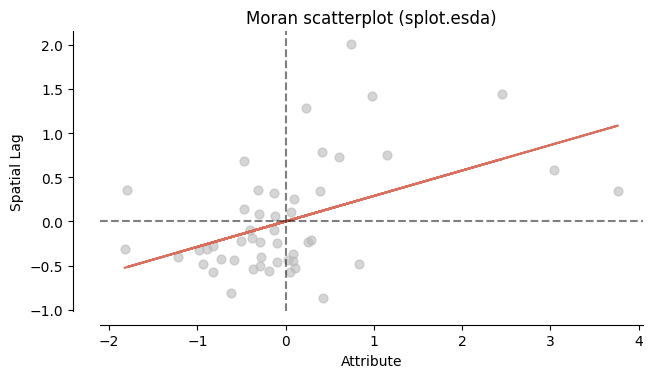

In [57]:
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moran_migration)  # строит диаграмму по объекту Moran
ax.set_title("Moran scatterplot (splot.esda)")
plt.show()

**Как интерпретировать график?**

Если на диаграмме наблюдается концентрация точек в **правом верхнем (High–High)** и **левом нижнем (Low–Low)** квадрантах, это указывает на то, что территории с высокими значениями показателя, как правило, соседствуют с территориями с высокими значениями, а территории с низкими значениями — с территориями с низкими значениями. Такая картина соответствует **положительной пространственной автокорреляции** и согласуется с положительным значением индекса Морана.

Если же значительная часть точек располагается в **правом нижнем (High–Low)** и **левом верхнем (Low–High)** квадрантах, это означает, что территории с высокими значениями чаще соседствуют с территориями с низкими значениями и наоборот. В этом случае наблюдается **отрицательная пространственная автокорреляция**, что соответствует отрицательному значению индекса Морана.

При отсутствии выраженной концентрации точек в определённых квадрантах и их близком к случайному распределении можно говорить о слабой или отсутствующей пространственной структуре, что обычно соответствует значениям индекса Морана, близким к нулю.

> Диаграмма рассеяния Морана показывает, склонны ли соседние территории иметь похожие или контрастные отклонения значений показателя от среднего.


> Глобальный индекс Морана и диаграмма рассеяния Морана позволяют сделать вывод о **наличии или отсутствии пространственной автокорреляции в целом по всей исследуемой территории**. Однако они не отвечают на важный вопрос: **где именно в пространстве формируется наблюдаемая структура**.
>
> Для более детального анализа используется **локальный индекс Морана (LISA, Local Indicators of Spatial Association)**, который позволяет перейти от общего результата к анализу отдельных пространственных объектов.


## 2. Local Morans's I (LISA)


**Local Moran’s I (LISA)** — это показатель **локальной пространственной автокорреляции**, который используется для анализа пространственных закономерностей **на уровне отдельных пространственных объектов**.

В отличие от глобального индекса Морана, который даёт обобщённую оценку пространственной зависимости по всей исследуемой территории, Local Moran’s I показывает, **как каждый конкретный объект связан со своим непосредственным пространственным окружением**.

Иными словами, LISA отвечает на вопрос:
**является ли значение показателя на данной территории согласованным со значениями у её соседей, и если да, то каким образом**.

Использование локального индекса Морана позволяет обнаружить два основных типа пространственных закономерностей.

**1. Локальные пространственные кластеры**

Кластеры представляют собой группы соседних объектов с похожими значениями показателя:

- **High–High (HH)** — объект с высокой величиной показателя окружён объектами с высокими значениями;
- **Low–Low (LL)** — объект с низкой величиной показателя окружён объектами с низкими значениями.

**2. Пространственные аномалии (локальные выбросы)**

Пространственные аномалии возникают в случаях, когда значение показателя в объекте резко отличается от значений у его соседей:

- **High–Low (HL)** — объект с высоким значением среди объектов с низкими значениями;
- **Low–High (LH)** — объект с низким значением среди объектов с высокими значениями.

LISA для объекта ( i ) вычисляется по формуле:

$$
I_i = z_i \sum_{j} w_{ij} z_j,
$$

где:

- $I_i$ — значение локального индекса Морана для объекта $i$;
- $z_i$ — стандартизированное значение анализируемого показателя для объекта $i$;
- $w_{ij}$ — элемент матрицы пространственных весов, отражающий наличие и силу связи между объектами $i$ и $j$;
- сумма берётся по всем объектам $j$, являющимся соседями объекта $i$;
- $z_j$ — стандартизированные значения показателя для соседних объектов.

Стандартизированное значение рассчитывается как:

$$
z_i = \frac{x_i - \overline{x}}{s},
$$

где $\overline{x}$ — среднее значение показателя, а $s$ — его стандартное отклонение.

**Значения LISA интерпретируются следующим образом**:

- если

  $$
  I_i > 0,
  $$

  то значение показателя в объекте **похоже на значения у его соседей**, что соответствует локальному кластеру типов **HH** или **LL**;

- если
  $$
  I_i < 0,
  $$
  то значение показателя в объекте **контрастирует со значениями у соседей**, что указывает на пространственную аномалию типов **HL** или **LH**.


По аналогии с глобальным индексом Морана, мы сначала посчитаем LISA вручную, а затем с помощью функции из библиотеки esda.


### LISA по шагам


> Многие из этих шагов уже выполнялись выше при расчёте глобального индекса Морана.
> Здесь мы повторяем их, чтобы последовательно и полностью показать процесс расчёта локальных индексов пространственной автокорреляции (LISA)


#### ШАГ 1. Подготовка данных


**1.1. Исключение наблюдений с пропущенными значениями**

Перед расчётом индекса Морана из анализа исключаются муниципальные образования, для которых отсутствуют значения анализируемого показателя (NaN). Это необходимо, поскольку индекс Морана рассчитывается на основе сравнения значений показателя между соседними территориями. При отсутствии значения для отдельного объекта невозможно корректно учесть его вклад и вклад его соседей в общий показатель пространственной автокорреляции.


In [58]:
muni_clean = muni.copy()
muni_clean = muni_clean[muni_clean["netMigrationRate1000_2020"].notna()].reset_index(drop=True)

#### ШАГ 2. Матрица весов ( W )

На данном шаге определяется, **какие пространственные объекты считаются соседними**, то есть какие территории будут сравниваться между собой при расчёте индекса Морана.

Будем использоваь соседство типа _Queen_: два объекта считаются соседями, если они имеют общую границу или соприкасаются углами.

**2.1. Матрица смежности (определение соседства)**

Построим **матрицу смежности**, строки и столбцы которой соответствуют пространственным объектам ( в нашем случае - муниципальным образованиям).

В матрице будут записаны следующие значения:

- **1** — если соответствующие объекты являются соседями,
- **0** — если соседство между объектами отсутствует.


In [59]:
# n — количество пространственных объектов (полигонов)
n = len(muni_clean)

# Создаём пустую матрицу весов n × n
# Пока все элементы равны 0 (соседство не задано)
W = np.zeros((n, n))


# Проходим по всем парам объектов i и j
for i in range(n):
    for j in range(n):

        # Объект не может быть соседом самому себе
        if i != j:

            # Проверяем, соприкасаются ли два полигона
            # touches = общая граница или общая вершина (Queen-соседство)
            if muni_clean.geometry.iloc[i].touches(muni_clean.geometry.iloc[j]):

                # Если объекты i и j являются соседями,
                # записываем 1 в матрицу весов
                W[i, j] = 1


После построения матрицы смежности проводится проверка корректности её формирования. В качестве простой "диагностики" используется сумма всех элементов матрицы, которая отражает общее число соседских связей между объектами.


In [60]:
print("W.sum() =", W.sum())

# Доп. проверка: есть ли объекты без соседей (строка из нулей)
row_sums = W.sum(axis=1)
print("Объектов без соседей:", np.sum(row_sums == 0))

W.sum() = 218.0
Объектов без соседей: 0


Значение `W.sum()` показывает общее количество зафиксированных соседских связей между объектами. Если `W.sum() = 0`, значит соседства не были обнаружены, и матрица построена неверно.


**2.2. Стандартизация матрицы пространственных весов**

После построения матрицы смежности матрица пространственных весов ( W ) обычно **стандартизируется по строкам** -- для каждого пространственного объекта сумма весов его соседей приводится к единице

Формально стандартизация выполняется следующим образом:

$$
w_{ij}^{*} = \frac{w_{ij}}{\sum_j w_{ij}},
$$

где $w_{ij}$ — элемент исходной матрицы смежности, а $\sum_j w_{ij}$ — количество соседей объекта $i$.

В результате стандартизации каждый элемент матрицы $w_{ij}^{*}$ показывает **относительный вклад соседа $j$** в пространственное окружение объекта $i$: чем больше у объекта соседей, тем меньший вес получает каждый из них.

Стандартизация матрицы пространственных весов необходима, так как:

- разные объекты могут иметь разное количество соседей;
- без стандартизации объекты с большим числом соседей оказывали бы непропорционально большое влияние на результат;
- стандартизация позволяет сделать вклад всех объектов сопоставимым и корректно сравнивать их между собой.


In [61]:
W_row = W.astype(float).copy()

for i in range(n):
    s = W_row[i].sum()
    if s > 0:
        W_row[i] = W_row[i] / s
    # если s == 0, оставляем строку из нулей (у объекта нет соседей)

# Проверка: суммы по строкам должны быть 1 (там, где соседи есть)
row_sums_after = W_row.sum(axis=1)
print("Мин. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].min())
print("Макс. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].max())

Мин. сумма по строкам после стандартизации: 0.9999999999999999
Макс. сумма по строкам после стандартизации: 1.0


Теперь сумма весов в каждой строке = 1 (или почти 1 - 0.9999 - в рамках погрешности)


#### ШАГ 3. Расчёт среднего значения и отклонений от среднего

Давайте рассчитаем значения, которые непосредственно используются в индексе Морана – среднее значение показателя и отклонения от среднего

**3.1. Расчёт среднего значения показателя**

Сначала вычислим среднее значение анализируемого показателя по всем пространственным объектам:
$
\overline{x}.
$


In [62]:
# Вектор исходных значений показателя x_i (чистая миграция по муниципалитетам)
x = muni_clean["netMigrationRate1000_2020"].values

# Вычисляем среднее значение показателя
x_mean = x.mean()


print("Среднее значение показателя:", x_mean)

Среднее значение показателя: 3.7871428571428574


**3.2. Расчёт отклонений от среднего и их стандартизация**

При расчёте индеска Морана мы для каждого объекта вычисляли отклоение значения показателя от среднего:
[
x_i - \overline{x}.
]

Для расчёта **локального индекса Морана (LISA)** этих отклонений недостаточно. Дело в том, что локальный анализ предполагает **сравнение вкладов разных объектов**, поэтому важно, чтобы значения показателя были приведены к **единой и сопоставимой шкале**.

С этой целью отклонения от среднего **дополнительно стандартизируются**, то есть делятся на стандартное отклонение показателя. В результате для каждого объекта вычисляется стандартизированное значение (_z-score_):

$$
\color{#2f855a}{z_i = \frac{x_i - \overline{x}}{s}}
$$

где:

- ( x_i ) — значение показателя в объекте ( i );
- ( \overline{x} ) — среднее значение показателя по всем объектам;
- ( s ) — стандартное отклонение показателя.

**Как вычисляется стандартное отклонение**

Стандартное отклонение отражает **типичный масштаб разброса значений показателя** и вычисляется по формуле:

$$
s = \sqrt{\frac{1}{n} \sum_i (x_i - \overline{x})^2},
$$

где:

- $n$ — число пространственных объектов;
- $(x_i - \overline{x})^2$ — квадрат отклонения значения показателя от среднего.

**Зачем нужна стандартизация**

Стандартизация позволяет интерпретировать значения показателя **относительно среднего уровня**:

- если

  $$
  z_i > 0,
  $$

  то значение показателя в объекте **выше среднего**;

- если

  $$
  z_i < 0,
  $$

  то значение показателя **ниже среднего**;

- величина
  $$
  |z_i|
  $$
  показывает, **насколько сильно** объект отличается от среднего по всей территории.

**Место в формуле LISA**

Полученные стандартизированные значения ( z_i ) напрямую используются в формуле локального индекса Морана:

$$
I_i =
\color{#2f855a}{z_i}
\sum_j w_{ij}
\color{#2f855a}{z_j}.
$$

На данном этапе расчёта подготавливаем **ключевой элемент этой формулы** — стандартизированные значения показателя:

- $z_i$ — для самого объекта;
- $z_j$ — для его соседей.

Именно на основе этих величин далее оценивается, **насколько значение в объекте согласуется или контрастирует со значениями в его пространственном окружении**.


In [63]:
# Стандартное отклонение показателя ( s )
# ddof=1 — используем выборочное стандартное отклонение
x_std = x.std(ddof=1)

# Стандартизованные отклонения (z-score):
# показывают, насколько значение в объекте выше или ниже среднего
z = (x - x_mean) / x_std


#### ШАГ 4. Расчёт пространственного лага (влияние соседей)

После того как для каждого объекта рассчитаны стандартизированные значения показателя $z_i$, необходимо учесть **пространственное окружение** каждого объекта, то есть значения показателя у его соседей.

Для этого рассчитывается **пространственный лаг**, который представляет собой взвешенную сумму стандартизированных значений соседних объектов.

Для объекта $i$ пространственный лаг вычисляется по формуле:

$$
\color{#3182ce}{Wz_i = \sum_j w_{ij} z_j},
$$

где:

- $Wz_i$ — пространственный лаг для объекта $i$;
- $w_{ij}$ — элемент матрицы пространственных весов, отражающий наличие и силу соседства между объектами $i$ и $j$;
- $z_j$ — стандартизированное значение показателя для соседнего объекта $j$;
- суммирование проводится по всем соседям объекта $i$.

Простыми словами:

- мы берём **все соседние объекты $j$** для объекта $i$;
- умножаем значение каждого соседа $z_j$ на соответствующий вес $w_{ij}$;
- складываем полученные произведения.

**Интуитивный смысл пространственного лага**

Пространственный лаг показывает, **какие значения показателя характерны для окружения объекта**:

- если

  $$
  Wz_i > 0,
  $$

  то в окружении объекта преобладают значения **выше среднего**;

- если

  $$
  Wz_i < 0,
  $$

  то в окружении объекта преобладают значения **ниже среднего**;

- если
  $$
  Wz_i \approx 0,
  $$
  то значения у соседей в среднем близки к среднему по всей территории.

Пространственный лаг позволяет описать **локальный контекст**, в котором находится объект ( i ).

Рассчитанный пространственный лаг является второй ключевой частью формулы локального индекса Морана:

$$
I_i =
\color{#2f855a}{z_i}
\cdot
\color{#3182ce}{\sum_j w_{ij} z_j}.
$$


In [64]:
# Пространственно взвешенные значения соседей
wz = W_row @ z

#### ШАГ 5. Расчёт локального индекса Морана (I_i)

На предыдущих этапах мы рассчитали:

- стандартизированное значение показателя для объекта ( i ), ( z_i );
- пространственный лаг, отражающий значения показателя у соседних объектов, ( Wz_i ).

На данном шаге эти две величины объединяются для вычисления **локального индекса Морана**.

Локальный индекс Морана для каждого объекта рассчитывается как произведение его собственного стандартизированного значения и среднего значения его соседей:

$$
\color{#805ad5}{I_i = z_i \cdot \sum_j w_{ij} z_j}
$$


In [65]:
# Локальные значения Moran's I (LISA)
Ii = z * wz

Смысл этой величины:

- большие положительные значения (I_i) указывают на **локальную кластеризацию**;
- отрицательные значения (I_i) указывают на **пространственные выбросы**.


> LISA сравнивает значение показателя в каждом объекте с усреднёнными значениями у его соседей и позволяет выявить локальные кластеры и пространственные выбросы, которые не видны при использовании глобальных показателей.


#### Как определяется принадлежность к кластерам?


Тип кластера (или “паттерна”) задаётся **знаками** (z_i) и (Wz_i). Это буквально те же квадранты Moran scatterplot:

**1) HH — High–High (локальный кластер высоких)**

$$
z_i > 0,\quad Wz_i > 0.
$$

Объект **выше среднего** и окружён соседями **выше среднего**.

**2) LL — Low–Low (локальный кластер низких)**

$$
z_i < 0,\quad Wz_i < 0.
$$

Объект **ниже среднего** и окружён соседями **ниже среднего**.

**3) HL — High–Low (локальная аномалия: высокий среди низких)**

$$
z_i > 0,\quad Wz_i < 0.
$$

**4) LH — Low–High (локальная аномалия: низкий среди высоких)**

$$
z_i < 0,\quad Wz_i > 0.
$$


### Расчёт LISA с библиотекой esda


In [66]:
# Рассчитываем локальный индекс Морана для ДТП
local_moran = esda.Moran_Local(muni_clean['netMigrationRate1000_2020'], w)

# Получаем локальные значения индекса Морана для каждого региона
local_moran_values = local_moran.Is  # Это значения индекса Морана для каждого элемента
print(local_moran_values)


[-0.05806776 -0.31533015  0.00672817  0.14250806 -0.10705746  0.4596399
 -0.03499515 -0.00759866 -0.39282979  0.06622086 -0.06038852  0.10792555
 -0.01352756  0.03852756 -0.04062    -0.05527756  0.10928648  0.13254698
  0.25055711  0.30766924  0.04407877  0.1971904   0.48055856  0.06927641
  0.42649241 -0.02404821  0.30983262 -0.35649215 -0.02932321  0.10194689
  0.28981067  0.01244329  0.44114297  0.0242414   0.49135408 -0.61436083
  0.27124158  0.22159067 -0.06230919  0.85549596  1.26442503  1.73900227
  0.3154164   0.02331998  1.45441482  3.47022595  1.35891774 -0.02576835
  0.55142142]


В local_moran.q мы можем узнать к какому кластеру (HH, LL, HL, LH) попадает каждая из ячеек


In [67]:
local_moran.q

array([4, 2, 1, 3, 2, 3, 4, 2, 4, 3, 4, 3, 4, 3, 2, 4, 3, 1, 3, 3, 3, 3,
       3, 3, 1, 2, 3, 4, 4, 3, 1, 3, 3, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 3,
       1, 1, 1, 4, 3])

#### Построим LISA Cluster Map


**LISA Cluster Map** — это карта локальных кластеров индекса Морана, которая показывает, где именно в пространстве формируются значимые группы высоких или низких значений. В отличие от глобального индекса Морана, который оценивает пространственную зависимость в целом, LISA анализируется отдельно для каждой ячейки и её соседей.

Карта выделяет четыре типа зон: **HH** (высокие значения среди высоких), **LL** (низкие среди низких), **HL** (высокие среди низких — аномальные пики) и **LH** (низкие среди высоких )


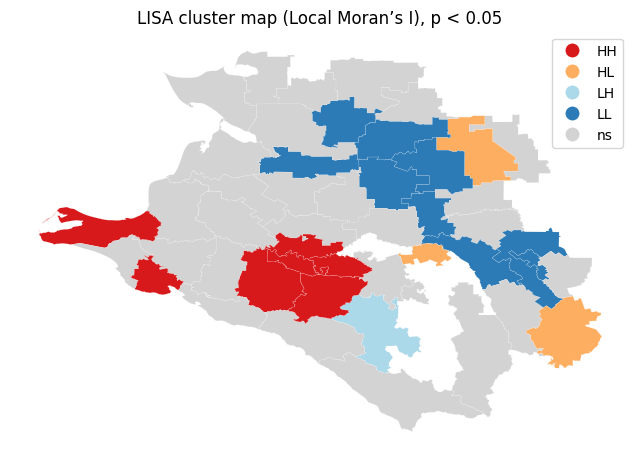

In [68]:
from splot.esda import lisa_cluster

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

lisa_cluster(local_moran, muni_clean, p=0.15, ax=ax)

ax.set_title("LISA cluster map (Local Moran’s I), p < 0.05")
plt.show()

## 3. Bivariate Moran I


До этого момента анализ пространственной автокорреляции был сосредоточен на **одном показателе**: мы изучали, склонны ли соседние территории иметь **похожие или контрастные значения одной и той же переменной**. Такой подход называется **одновариантным (univariate)** пространственным анализом.

Однако на практике часто возникает более сложный и содержательный вопрос:
**связаны ли значения одного показателя в данной территории со значениями другого показателя в соседних территориях**.

Для ответа на этот вопрос используется **двухвариантный индекс Морана (Bivariate Moran’s I)**.

Bivariate Moran’s I позволяет оценить **пространственную связь между двумя различными переменными**, учитывая структуру соседства. В отличие от классического индекса Морана, здесь сравниваются:

- значение первой переменной в объекте $i$;
- значения второй переменной у **соседних объектов** $j$.

Иными словами, двухвариантный индекс Морана отвечает на вопрос:

> _Связаны ли значения одного показателя в данной территории с пространственным распределением другого показателя вокруг неё?_

Методологически двухвариантный индекс Морана строится на тех же принципах, что и одновариантный:

- используется та же матрица пространственных весов;
- применяются центрированные (или стандартизированные) значения;
- интерпретация основана на анализе знаков и пространственных лагов.


Давайте рассчитаем Bivariate Moran I для значений коэффициентов убытия и прибытия по рассматриваемым муниципалитетам


In [69]:
from pysal.explore import esda

# X — коэффициент прибытия (в самом муниципалитете)
# Y — коэффициент убытия (у соседей)
x = muni_clean['netMigrationRate1000_2020'].values
y = muni_clean['outMigrationRate1000_2020'].values

moran_bv = esda.Moran_BV(x, y, w, permutations=999)

print(
    "Bivariate Moran's I "
    "(коэффициент прибытия ~ коэффициент убытия у соседей): "
    f"{moran_bv.I:.3f}"
)
print(f"p-value: {moran_bv.p_sim:.3f}")

Bivariate Moran's I (коэффициент прибытия ~ коэффициент убытия у соседей): 0.228
p-value: 0.003


Полученное значение двухвариантного индекса Морана показывает характер пространственной связи между коэффициентом прибытия в муниципалитете и коэффициентом убытия в соседних муниципалитетах. Положительное значение индекса указывает на то, что территории с высоким коэффициентом прибытия, как правило, окружены территориями с высоким коэффициентом убытия, тогда как отрицательное значение индекса свидетельствует об обратной зависимости. Статистическая значимость результата оценивается на основе пермутационного теста.


Диаграмма рассеяния Bivariate Moran


Диаграмма рассеяния двухвариантного индекса Морана позволяет визуально оценить, за счёт каких муниципалитетов формируется наблюдаемая пространственная связь. Концентрация точек в верхнем правом и нижнем левом квадрантах указывает на положительную пространственную зависимость, тогда как преобладание точек в противоположных квадрантах свидетельствует об отрицательной зависимости.


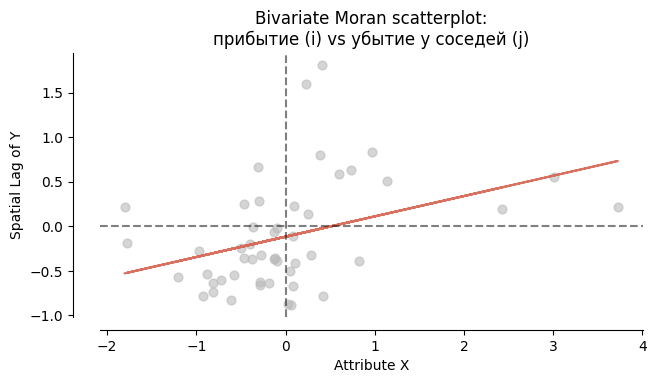

In [70]:
from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt

fig, ax = moran_scatterplot(moran_bv)
ax.set_title(
    "Bivariate Moran scatterplot:\n"
    "прибытие (i) vs убытие у соседей (j)"
)
plt.show()

## 4. Итог


В этом разделе мы рассмотрели основные подходы к анализу **пространственной автокорреляции**.

- **Глобальный индекс Морана** используется для выявления пространственной структуры одного показателя.
- **Локальные индексы Морана (LISA)** позволяют определить, где именно формируются кластеры и пространственные выбросы.
- **Bivariate индекс Морана** применяется для анализа пространственной связи между **двумя различными показателями**, когда значение одной переменной сопоставляется с окружением другой.
- Все варианты индекса Морана опираются на матрицу пространственных весов, выбор которой влияет на результат анализа.
